# Introduction

Comparison between Conlloovia and FCMA.

In [1]:
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = "data.csv"
df = pd.read_csv(filename)
df.head()

,exp,napps,n_fam,cores,mem_mul,perf,frac_gap,add_ccs,Conlloovia_vars,Conlloovia_status,...,FFP_isolation_m,Fcma_1_0.5_isolation_m,Conlloovia_vm_recycling_m,FFC_vm_recycling_m,FFP_vm_recycling_m,Fcma_1_0.5_vm_recycling_m,Conlloovia_vm_load_balance_m,FFC_vm_load_balance_m,FFP_vm_load_balance_m,Fcma_1_0.5_vm_load_balance_m
0,0,1,1,0.12,2,0.02,0.02,False,1365,OPTIMAL,...,0.127841,0.076389,0.000000,0.000000,0.0,0.0,0.250,1.0,0.022727,0.500000
1,1,1,1,0.12,2,0.40,0.02,False,120,OPTIMAL,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000,1.0,1.000000,1.000000
2,2,1,1,0.12,8,0.02,0.02,False,260,OPTIMAL,...,0.250000,0.225000,0.333333,1.000000,0.0,1.0,0.200,1.0,0.100000,0.500000
3,3,1,1,0.12,8,0.40,0.02,False,120,OPTIMAL,...,0.333333,0.500000,1.000000,1.000000,1.0,1.0,1.000,1.0,1.000000,1.000000
4,4,1,1,3.00,2,0.02,0.02,False,999,OPTIMAL,...,1.000000,0.442177,0.000000,0.979592,0.0,1.0,0.125,0.2,0.018868,0.142857


In [3]:
# Simplify the name of the column All_lower_bound_d_h_0.5 to bound
df = df.rename(columns={'All_lower_bound_d_h_0.5': 'bound'})

In [4]:
# If Conlloovia_status is ABORTED or CBC_ERROR, set the Conlloovia_cost_d_h to pd.Na
df.loc[
    df["Conlloovia_status"].isin(["ABORTED", "CBC_ERROR"]), "Conlloovia_cost_d_h"
] = pd.NA

# If Conlloovia_status is CBC_ERROR, set the Conlloovia llower_bound_d_h to pd.Na
df.loc[df["Conlloovia_status"] == "CBC_ERROR", "Conlloovia_lower_bound_d_h"] = pd.NA

df.loc[df["Conlloovia_status"].isin(["ABORTED", "CBC_ERROR"])].head()

,exp,napps,n_fam,cores,mem_mul,perf,frac_gap,add_ccs,Conlloovia_vars,Conlloovia_status,...,FFP_isolation_m,Fcma_1_0.5_isolation_m,Conlloovia_vm_recycling_m,FFC_vm_recycling_m,FFP_vm_recycling_m,Fcma_1_0.5_vm_recycling_m,Conlloovia_vm_load_balance_m,FFC_vm_load_balance_m,FFP_vm_load_balance_m,Fcma_1_0.5_vm_load_balance_m
36,36,5,1,3.00,2,0.02,0.02,False,143583,ABORTED,...,1.000000,0.111362,NaN,0.0,0.0,1.000000,NaN,0.125470,0.000443,0.125830
50,50,15,1,0.12,8,0.02,0.02,False,254248,ABORTED,...,0.331461,0.044625,NaN,0.0,0.0,0.960912,NaN,0.076923,0.001292,0.306667
52,52,15,1,3.00,2,0.02,0.02,False,1096842,ABORTED,...,1.000000,0.089717,NaN,0.0,0.0,0.997691,NaN,0.058714,0.000143,0.162000
54,54,15,1,3.00,8,0.02,0.02,False,1100655,ABORTED,...,1.000000,0.093071,NaN,0.0,0.0,0.999006,NaN,0.012918,0.001632,0.084715
60,60,15,4,3.00,2,0.02,0.02,False,2408607,ABORTED,...,1.000000,0.291059,NaN,0.0,0.0,0.937785,NaN,0.112478,0.000309,0.274444


In [5]:
# Create a new status column with these values:
# - "Optimal" if Conlloovia_status is "OPTIMAL"
# - "Feasible" if Conlloovia_status is "INTEGER_FEASIBLE"
# - "No solution" if Conlloovia_status is "ABORTED" or "CBC_ERROR"
df["Conlloovia status"] = df["Conlloovia_status"].map(
    {
        "OPTIMAL": "Optimal",
        "INTEGER_FEASIBLE": "Feasible",
        "ABORTED": "No solution",
        "CBC_ERROR": "No solution",
    }
)

# Create a new status column for an algorithm: "Optimal" if its cost is equal to
# Conlloovia_cost_d_h and Conlloovia status is "OPTIMAL", or the algorithm cost is equal
# to the lower bound; "Feasible" otherwise
def heuristic_status(row, algo_cost_column):
    if row[algo_cost_column] == row["Conlloovia_cost_d_h"] and row["Conlloovia status"] == "Optimal":
        return "Optimal"
    elif row[algo_cost_column] == row["bound"]:
        return "Optimal"
    else:
        return "Feasible"
    
# Create new status columns for FFC, FFP and FCMA
df["FFC status"] = df.apply(heuristic_status, algo_cost_column="FFC_cost_d_h", axis=1)
df["FFP status"] = df.apply(heuristic_status, algo_cost_column="FFP_cost_d_h", axis=1)
df["FCMA status"] = df.apply(heuristic_status, algo_cost_column="Fcma_1_0.5_cost_d_h", axis=1)

In [6]:
# Compute the ratio of cost FCMA, FFC, and FFP to Conlloovia and the bound
SPEEDS = [1]
SFMPLS = [0.5]

for speed in SPEEDS:
    for sfmpl in SFMPLS:
        df[f"ratio_cost_fcma_{speed}_{sfmpl}_con"] = df[f"Fcma_{speed}_{sfmpl}_cost_d_h"] / df[
            "Conlloovia_cost_d_h"
        ]
df[f"ratio_cost_fcma_bound"] = df[f"Fcma_1_0.5_cost_d_h"] / df["bound"]

df["ratio_cost_ffc_con"] = df["FFC_cost_d_h"] / df["Conlloovia_cost_d_h"]
df["ratio_cost_ffp_con"] = df["FFP_cost_d_h"] / df["Conlloovia_cost_d_h"]

In [7]:
# Compute the ratio of cost of Conlloovia, FFC and FFP to FCMA
SPEEDS = [1]
SFMPLS = [0.5]

for speed in SPEEDS:
    for sfmpl in SFMPLS:
        df[f"ratio_cost_con_fcma_{speed}_{sfmpl}"] = df["Conlloovia_cost_d_h"] / df[
            f"Fcma_{speed}_{sfmpl}_cost_d_h"
        ]
        df[f"ratio_cost_ffc_fcma_{speed}_{sfmpl}"] = df["FFC_cost_d_h"] / df[
            f"Fcma_{speed}_{sfmpl}_cost_d_h"
        ]
        df[f"ratio_cost_ffp_fcma_{speed}_{sfmpl}"] = df["FFP_cost_d_h"] / df[
            f"Fcma_{speed}_{sfmpl}_cost_d_h"
        ]

# Compute the ratio of cost of FCMA to the bound
df[f"ratio_cost_fcma_bound"] = df[f"Fcma_1_0.5_cost_d_h"] / df["bound"]

In [8]:
# Compute total times
df["Conlloovia_total_time_s"] = df["Conlloovia_creation_time_s"] + df["Conlloovia_solving_time_s"]
df["FFC_total_time_s"] = df["FFC_creation_time_s"] + df["FFC_solving_time_s"]
df["FFP_total_time_s"] = df["FFP_creation_time_s"] + df["FFP_solving_time_s"]

for speed in SPEEDS:
    for sfmpl in SFMPLS:
        df[f"Fcma_{speed}_{sfmpl}_total_time_s"] = df[f"Fcma_{speed}_{sfmpl}_pre_alloc_time_s"] + df[
            f"Fcma_{speed}_{sfmpl}_alloc_time_s"
        ]

In [9]:

# Show a table with the statuses in the rows and the number of scenarios for each status
# of the different techniques. The order of the rows is "Optimal", "Feasible", "No solution".
status_counts = []
for technique in ["Conlloovia", "FFC", "FFP", "FCMA"]:
    status_counts.append(df[f"{technique} status"].value_counts())

# Concatenate the counts of the different techniques
status_counts = pd.concat(status_counts, axis=1).fillna(0).astype(int)

# Rename the columns
status_counts.columns = ["Conlloovia", "FFC", "FFP", "FCMA"]

print(status_counts)

             Conlloovia  FFC  FFP  FCMA
Optimal              37    6    5    36
Feasible             29   74   75    44
No solution          14    0    0     0


In [10]:
# Print a table in latex, with the count of statuses for each scenario and technique, but
# adding in parenthesis the percentage of the total number of scenarios that each status
# represents from the total number of scenarios, i.e., the sum of each column
# Calculate percentages
percentages = status_counts.div(status_counts.sum(axis=0), axis=1) * 100

# Combine counts and percentages in the format "count (percentage%)"
formatted_table = status_counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"

# The order of the columns should be "FCMA", "Conlloovia", "FFC" and "FFP"
formatted_table = formatted_table[["FCMA", "Conlloovia", "FFC", "FFP"]]

# Generate LaTeX code
latex_code = formatted_table.to_latex(index=True, escape=True)
print(latex_code)


\begin{tabular}{lllll}
\toprule
 & FCMA & Conlloovia & FFC & FFP \\
\midrule
Optimal & 36 (45.0\%) & 37 (46.2\%) & 6 (7.5\%) & 5 (6.2\%) \\
Feasible & 44 (55.0\%) & 29 (36.2\%) & 74 (92.5\%) & 75 (93.8\%) \\
No solution & 0 (0.0\%) & 14 (17.5\%) & 0 (0.0\%) & 0 (0.0\%) \\
\bottomrule
\end{tabular}



In [11]:
# Find the smallest scenario where Conlloovia doesn't find a solution and the largest where it finds one
df.loc[df["Conlloovia status"] == "No solution"].sort_values("Conlloovia_vars").head(1)

,exp,napps,n_fam,cores,mem_mul,perf,frac_gap,add_ccs,Conlloovia_vars,Conlloovia_status,...,ratio_cost_fcma_bound,ratio_cost_ffc_con,ratio_cost_ffp_con,ratio_cost_con_fcma_1_0.5,ratio_cost_ffc_fcma_1_0.5,ratio_cost_ffp_fcma_1_0.5,Conlloovia_total_time_s,FFC_total_time_s,FFP_total_time_s,Fcma_1_0.5_total_time_s
36,36,5,1,3.0,2,0.02,0.02,False,143583,ABORTED,...,1.043137,NaN,NaN,NaN,1.0,1.413534,610.7087,0.7818,1.6247,0.6252


In [12]:
df.loc[df["Conlloovia status"].isin(["Optimal", "Feasible"])].sort_values("Conlloovia_vars", ascending=False).head(1)

,exp,napps,n_fam,cores,mem_mul,perf,frac_gap,add_ccs,Conlloovia_vars,Conlloovia_status,...,ratio_cost_fcma_bound,ratio_cost_ffc_con,ratio_cost_ffp_con,ratio_cost_con_fcma_1_0.5,ratio_cost_ffc_fcma_1_0.5,ratio_cost_ffp_fcma_1_0.5,Conlloovia_total_time_s,FFC_total_time_s,FFP_total_time_s,Fcma_1_0.5_total_time_s
56,56,15,4,0.12,2,0.02,0.02,False,1012051,INTEGER_FEASIBLE,...,1.040106,5.85117,6.165704,1.247966,7.302064,7.694592,683.2929,0.5852,1.445,0.6796


# Figures

In [13]:
# Put the data frame in the long format
df_long = pd.melt(
    df,
    id_vars=["Conlloovia_vars", "Conlloovia status", "FCMA status", "napps"],
    value_vars=["ratio_cost_fcma_bound", "ratio_cost_con_fcma_1_0.5", "ratio_cost_ffc_fcma_1_0.5", "ratio_cost_ffp_fcma_1_0.5"],
    var_name="ratio_type",
    value_name="ratio",
)

df_long.head()

,Conlloovia_vars,Conlloovia status,FCMA status,napps,ratio_type,ratio
0,1365,Optimal,Optimal,1,ratio_cost_fcma_bound,1.000000
1,120,Optimal,Optimal,1,ratio_cost_fcma_bound,1.000000
2,260,Optimal,Optimal,1,ratio_cost_fcma_bound,1.000000
3,120,Optimal,Optimal,1,ratio_cost_fcma_bound,1.000000
4,999,Optimal,Feasible,1,ratio_cost_fcma_bound,1.020619


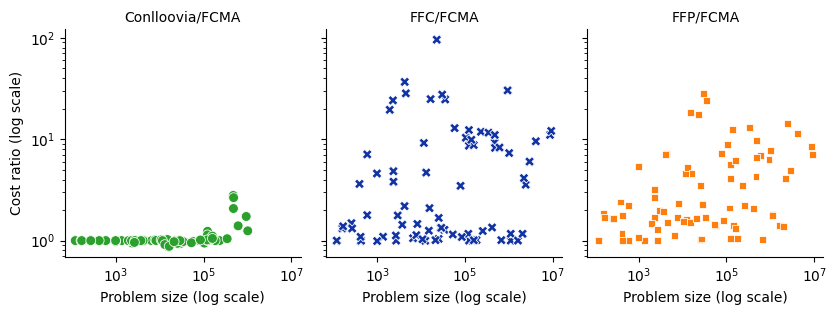

In [14]:
# Plot the ratio of the other algorithms to FCMA vs the problem size
ratios = ["ratio_cost_con_fcma_1_0.5", "ratio_cost_ffc_fcma_1_0.5", "ratio_cost_ffp_fcma_1_0.5"]
data_fig1 = df_long[(df_long["ratio_type"].isin(ratios))].copy()

short_names = ["Conlloovia/FCMA", "FFC/FCMA", "FFP/FCMA"]
data_fig1["ratio_type"] = data_fig1["ratio_type"].str.replace("ratio_cost_con_fcma_1_0.5", short_names[0])
data_fig1["ratio_type"] = data_fig1["ratio_type"].str.replace("ratio_cost_ffc_fcma_1_0.5", short_names[1])
data_fig1["ratio_type"] = data_fig1["ratio_type"].str.replace("ratio_cost_ffp_fcma_1_0.5", short_names[2])

g = sns.relplot(
    x="Conlloovia_vars",
    y="ratio",
    hue="ratio_type",
    style="ratio_type",
    col="ratio_type",
    kind="scatter",
    data=data_fig1,
    s=50, # size of the markers
    aspect=0.7,
    height=3.25,
    palette={short_names[0]: "#2ca02c", short_names[1]: "#1133a3", short_names[2]: "#ff7f0e"},
)

g.set_titles("{col_name}")

# g._legend.set_bbox_to_anchor((0.55, 0.38))  # Adjust the legend position
g._legend.remove()

# Use log for the x axis
plt.xscale("log")
plt.yscale("log")

# Improve the name of the ratio types and the conlloovia status
# plt.suptitle("Cost ratio FCMA/Conlloovia and FCMA/lower_bound vs problem size")
# plt.xlabel("Conlloovia variable count (log scale)")
g.set_xlabels("Problem size (log scale)")
g.set_ylabels("Cost ratio (log scale)")

# Use as ylabel in the first row "Ratio FCMA/Conlloovia"
# for ax, title in zip(g.axes.flat, ["Ratio FCMA/Conlloovia"]):
#     ax.set_ylabel(title)

# Remove the titles of the rows
# for ax in g.axes.flat:
#     ax.set_title("")

# plt.legend(bbox_to_anchor=(0.25, 0.3), loc='upper center', borderaxespad=0., title="Conlloovia solution").get_frame().set_facecolor('white')
# plt.legend().get_frame().set_facecolor('white')

# Move the legend right
# plt.legend(loc='center left', bbox_to_anchor=(2, 0.5))


# Add a grid
# plt.grid()

# Improve the axis to compare with the next plot
# plt.ylim(0)
# plt.xlim(0, 1e7)

plt.tight_layout()

plt.savefig(f"res_cost_1.png", dpi=600, bbox_inches='tight')

In [15]:
# Show the maximum and minimum ratio for each ratio type
for ratio in ratios:
    print(ratio)
    print(df_long[df_long["ratio_type"] == ratio].groupby("ratio_type")["ratio"].agg(["min", "max"]))   

ratio_cost_con_fcma_1_0.5
                               min       max
ratio_type                                  
ratio_cost_con_fcma_1_0.5  0.86939  2.786877
ratio_cost_ffc_fcma_1_0.5
                                min        max
ratio_type                                    
ratio_cost_ffc_fcma_1_0.5  0.983607  95.744756
ratio_cost_ffp_fcma_1_0.5
                           min       max
ratio_type                              
ratio_cost_ffp_fcma_1_0.5  1.0  27.95201


In [16]:
# Add a column indicating if Conlloovia found a solution (status is not "No solution").
# The values should be "Found" and "Not found"
df_long["Conlloovia solution"] = df_long["Conlloovia status"].map(
    {"No solution": "Not found", "Optimal": "Found", "Feasible": "Found"}
)

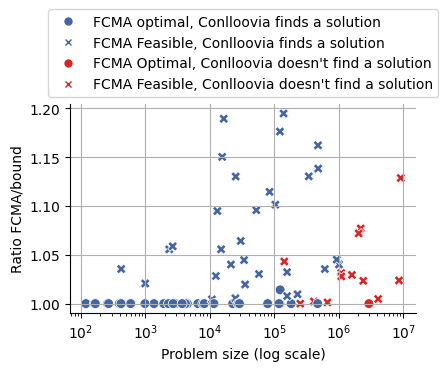

In [17]:
# Show the ratio of cost FCMA/lower_bound vs the problem size
data_fig2 = df_long[df_long["ratio_type"] == "ratio_cost_fcma_bound"]
g = sns.relplot(
    x="Conlloovia_vars",
    y="ratio",
    hue="Conlloovia solution",
    style="FCMA status",
    col="ratio_type",
    col_wrap=1,
    kind="scatter",
    data=data_fig2,
    s=50, # size of the markers
    aspect=1.1,
    height=3.2,
    palette={"Found": "#4365a1", "Not found": "#d62728"},
)

# g._legend.set_bbox_to_anchor((0.55, 0.38))  # Adjust the legend position
g._legend.remove()

# Use log for the x axis
plt.xscale("log")

# Improve the name of the ratio types and the conlloovia status
# plt.suptitle("Cost ratio FCMA/Conlloovia and FCMA/lower_bound vs problem size")
# plt.xlabel("Conlloovia variable count (log scale)")
plt.xlabel("Problem size (log scale)")

# Use as ylabel in the first row "Ratio FCMA/lower_bound"
for ax, title in zip(g.axes.flat, ["Ratio FCMA/bound"]):
    ax.set_ylabel(title)

# Remove the titles of the rows
for ax in g.axes.flat:
    ax.set_title("")

# Add a background color to the legend
# g._legend.get_frame().set_facecolor('white')
# g._legend.get_frame().set_alpha(1)

legend_handles = [
    mlines.Line2D([], [], color='#4365a1', marker='o', linestyle='None', markersize=5, label='FCMA optimal, Conlloovia finds a solution'),
    mlines.Line2D([], [], color='#4365a1', marker='x', linestyle='None', markersize=5, label='FCMA Feasible, Conlloovia finds a solution'),
    mlines.Line2D([], [], color='#d62728', marker='o', linestyle='None', markersize=5, label='FCMA Optimal, Conlloovia doesn\'t find a solution'),
    mlines.Line2D([], [], color='#d62728', marker='x', linestyle='None', markersize=5, label='FCMA Feasible, Conlloovia doesn\'t find a solution'),
]

legend = plt.legend(handles=legend_handles, ncol=1, bbox_to_anchor=(0.5, 1), loc='lower center')
legend.get_frame().set_facecolor('white')

# Add a grid
plt.grid()

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig(f"res_cost_2.png", dpi=600, bbox_inches='tight')

In [18]:
# Show the value where the ratio is the highest
data_fig2.loc[data_fig2["ratio"].idxmax()]

Conlloovia_vars                       139779
Conlloovia status                   Feasible
FCMA status                         Feasible
napps                                     15
ratio_type             ratio_cost_fcma_bound
ratio                               1.194669
Conlloovia solution                    Found
Name: 63, dtype: object

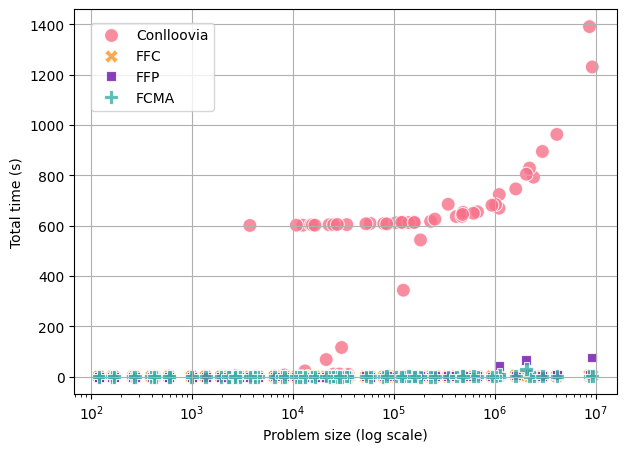

In [19]:
# Plot the total times
df_total_times_long = pd.melt(
        df,
        id_vars=["Conlloovia_vars"],
        value_vars=[
            "Conlloovia_total_time_s",
            "FFC_total_time_s",
            "FFP_total_time_s",
            "Fcma_1_0.5_total_time_s",
        ],
        var_name="variable",
        value_name="value",
    )

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="Conlloovia_vars",
    y="value",
    hue="variable",
    style="variable",
    alpha=0.8,
    data=df_total_times_long,
    palette={"Conlloovia_total_time_s": "#f77189", 
             "FFC_total_time_s": "#f7941e",
             "FFP_total_time_s": "#6a0dad",
             "Fcma_1_0.5_total_time_s": "#36ada4",
             },
    s=100, # size of the markers
)

# Use log for the x
plt.xscale("log")
# plt.yscale("log")

plt.legend(loc="right", bbox_to_anchor=(0.27, 0.85))

# Improve the name of the ratio types and the conlloovia status
plt.xlabel("Problem size (log scale)")
plt.ylabel("Total time (s)")

plt.grid()

legend = plt.gca().get_legend()

# Define the new labels
new_labels = [
    "Conlloovia",
    "FFC",
    "FFP",
    "FCMA",
]

# Set the text of each legend item to the corresponding new label
for t, l in zip(legend.texts, new_labels):
    t.set_text(l)

plt.savefig(f"res_time.png", dpi=600, bbox_inches='tight')

In [20]:
# Create a latex table with the average and maximum times (only total times)
times = df[["Conlloovia_total_time_s", "FFC_total_time_s", "FFP_total_time_s", "Fcma_1_0.5_total_time_s"]].agg(
    ["mean", "max"]).rename(
        columns={
            "Conlloovia_total_time_s": "Conlloovia",
            "FFC_total_time_s": "FFC",
            "FFP_total_time_s": "FFP",
            "Fcma_1_0.5_total_time_s": "FCMA"
        })

print(times.T.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
 & mean & max \\
\midrule
Conlloovia & 383.82 & 1390.17 \\
FFC & 0.50 & 4.89 \\
FFP & 3.25 & 75.90 \\
FCMA & 0.88 & 28.73 \\
\bottomrule
\end{tabular}



In [21]:
# Show the experiment where the FCMA time is the maximum
df.loc[df["Fcma_1_0.5_total_time_s"].idxmax()]

exp                                            70
napps                                          30
n_fam                                           1
cores                                         3.0
mem_mul                                         8
perf                                         0.02
frac_gap                                     0.02
add_ccs                                     False
Conlloovia_vars                           2042646
Conlloovia_status                         ABORTED
Conlloovia_lower_bound_d_h               2406.115
bound                                    2410.176
Conlloovia_cost_d_h                           NaN
FFC_cost_d_h                             3017.196
FFP_cost_d_h                             3544.404
Fcma_1_0.5_cost_d_h                      2583.456
Conlloovia_creation_time_s               125.6235
Conlloovia_solving_time_s                678.3809
FFC_creation_time_s                        0.0059
FFC_solving_time_s                          4.889


In [22]:
# Obtain df_metrics_long, that has a column "metric" with the name of the metric (fault_tolerance_m, isolation_m, vm_load_balance_m and vm_recycling_m)
# and another indicating the technique (Conlloovia or FCMA; for the latter, using FCAM_1_0.5) and a column "value" with the value of the metric.

# Fix error in a column: Fcma_1_0.5_recycling_m should be Fcma_1_0.5_vm_recycling_m
df = df.rename(columns={"Fcma_1_0.5_recycling_m": "Fcma_1_0.5_vm_recycling_m"})

value_vars = []
for algo in ["Conlloovia", "FFC", "FFP", "Fcma_1_0.5"]:
    for metric in ["fault_tolerance_m_e_0.5", "isolation_m", "vm_load_balance_m", "vm_recycling_m"]:
        if algo == "Fcma_1_0.5" and "tolerance" in metric:
            metric = f"fault_tolerance_m"
        value_vars.append(f"{algo}_{metric}")

df_metrics_long = pd.melt(
    df,
    id_vars=["Conlloovia_vars"],
    value_vars=value_vars,
    var_name="variable",
    value_name="value",
)

def metric_from_var_name(var_name):
    if "fault_tolerance_m" in var_name:
        return "Fault tolerance"
    elif "isolation_m" in var_name:
        return "Container isolation"
    elif "vm_load_balance_m" in var_name:
        return "Load balancing reduction"
    elif "vm_recycling_m" in var_name:
        return "Node recycling"

def technique_from_var_name(var_name):
    if "Fcma" in var_name:
        return "FCMA"
    if "Conlloovia" in var_name:
        return "Conlloovia"
    if "FFC" in var_name:
        return "FFC"
    if "FFP" in var_name:
        return "FFP"

# Add to df_metrics_long the metric name and if it's about Conlloovia or FCMA
df_metrics_long["metric"] = df_metrics_long.variable.apply(lambda x: metric_from_var_name(x))
df_metrics_long["technique"] = df_metrics_long.variable.apply(lambda x: technique_from_var_name(x))

In [23]:
# Show a table with the average and the standard deviation of the metrics for each
# technique. In each cell, show the average and the standard deviation in parenthesis
metric_summary = df_metrics_long.groupby(["metric", "technique"]).value.agg(["mean", "std"])

# Format each cell as "mean (std)"
formatted_summary = metric_summary.apply(lambda row: f"{row['mean']:.2f} ({row['std']:.2f})", axis=1)

# Unstack to pivot the table, creating columns for techniques
formatted_table = formatted_summary.unstack()

# Reorder columns if needed
formatted_table = formatted_table[['Conlloovia', 'FFC', 'FFP', 'FCMA']]

# Display the table
formatted_table

technique,Conlloovia,FFC,FFP,FCMA
metric,,,,
Container isolation,0.31 (0.24),0.07 (0.12),0.62 (0.40),0.31 (0.25)
Fault tolerance,0.25 (0.36),0.26 (0.37),0.81 (0.30),0.42 (0.42)
Load balancing reduction,0.38 (0.34),0.49 (0.42),0.09 (0.21),0.58 (0.31)
Node recycling,0.27 (0.39),0.37 (0.46),0.09 (0.29),0.72 (0.34)


In [24]:
# Generate the LaTeX code
latex_code = formatted_table.to_latex(escape=True)
print(latex_code)

\begin{tabular}{lllll}
\toprule
technique & Conlloovia & FFC & FFP & FCMA \\
metric &  &  &  &  \\
\midrule
Container isolation & 0.31 (0.24) & 0.07 (0.12) & 0.62 (0.40) & 0.31 (0.25) \\
Fault tolerance & 0.25 (0.36) & 0.26 (0.37) & 0.81 (0.30) & 0.42 (0.42) \\
Load balancing reduction & 0.38 (0.34) & 0.49 (0.42) & 0.09 (0.21) & 0.58 (0.31) \\
Node recycling & 0.27 (0.39) & 0.37 (0.46) & 0.09 (0.29) & 0.72 (0.34) \\
\bottomrule
\end{tabular}

